In [173]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

#import warnings
#warnings.filterwarnings('ignore')

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


Detect if GPU available, otherwise use CPU

In [174]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


Load MNIST dataset of $28 \times 28$ images. Training does NOT use the test set.

In [175]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [176]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

# Primal Network

This is the definition of the neural classifier for a custom number of layers (depth) and width. The first layer has $28 \times 28$ features, and the output layer has ten output classes (0-9).

In [177]:
class Net(nn.Module):
  
  #Constructor with default NN width = 256 and default NN depth = 3
  def __init__(self, width=256, depth=3):
    super().__init__()
    self.layers = nn.ModuleList()
    self.width = width
    self.depth = depth
    for w in range(0, depth - 1):
      if w == 0:
        self.layers.append(nn.Linear(in_features = 28*28, out_features = width))
      elif w == depth - 2:
        self.layers.append(nn.Linear(in_features = width, out_features = 10))   
      else:
        self.layers.append(nn.Linear(in_features = width, out_features = width))
  
  def forward(self, t):
    '''
    On input T, performs a affine transformation, then
    a ReLU, then another affine transformation.
    '''
    self.z = []
    
    t = t.reshape(-1, 28*28)
    for i in range(0, self.depth - 1):
      t = self.layers[i](t)
      self.z.append(t)
      if i != self.depth - 2:
        t = F.relu(t)
    return t
  

Provided training code using Adam.

In [178]:
def train(net, criterion, trainloader, lr=0.001):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

Train the network using cross entropy loss. Note that this is equivalent to maximizing the KL-divergence.

In [179]:
net = Net(width=256, depth=5)
net.to(device)

criterion = nn.CrossEntropyLoss()

train(net, criterion, trainloader, 0.001)

Epoch 0 Iter: 0 Loss 2.32828426361084
Epoch 0 Iter: 500 Loss 0.2913295328617096
Epoch 0 Iter: 1000 Loss 0.4844508469104767
Epoch 0 Iter: 1500 Loss 1.3629039525985718
Epoch 0 Iter: 2000 Loss 0.7173793315887451
Epoch 0 Iter: 2500 Loss 0.7531834244728088
Epoch 0 Iter: 3000 Loss 0.07790659368038177
Epoch 0 Iter: 3500 Loss 0.5145361423492432
Epoch 0 Iter: 4000 Loss 1.0758308172225952
Epoch 0 Iter: 4500 Loss 0.09942088276147842
Epoch 0 Iter: 5000 Loss 0.1339796930551529
Epoch 0 Iter: 5500 Loss 0.02642098069190979
Epoch 0 Iter: 6000 Loss 0.043489377945661545
Epoch 0 Iter: 6500 Loss 0.21937903761863708
Epoch 0 Iter: 7000 Loss 0.01329648494720459
Epoch 0 Iter: 7500 Loss 0.18382121622562408
Epoch 0 Iter: 8000 Loss 0.017005546018481255
Epoch 0 Iter: 8500 Loss 2.1145076751708984
Epoch 0 Iter: 9000 Loss 0.009233800694346428
Epoch 0 Iter: 9500 Loss 0.37251466512680054
Epoch 0 Iter: 10000 Loss 0.00042898330138996243
Epoch 0 Iter: 10500 Loss 0.006602481938898563
Epoch 0 Iter: 11000 Loss 0.581469595432

In [180]:
test_iter = iter(testloader)

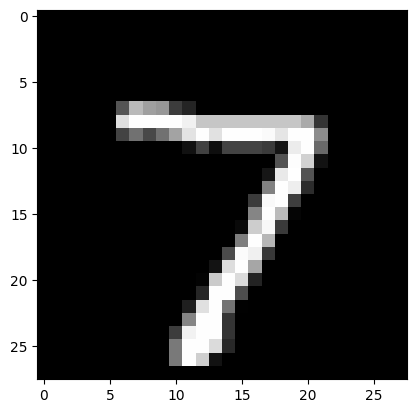

Classifier output: tensor([[-23.1510, -12.7656, -11.3955, -11.1384, -16.0372, -19.4963, -37.3320,
          -0.3459, -15.9774,  -8.5259]])
Classifier prediction: 7


In [181]:
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

Let's look at accuracy now.

In [182]:
def accuracy(net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [183]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.9685


Implement FGSM Method:

In [184]:
def FGSM(x, labels, net, eps):
    '''
    Given an input image X and its corresponding labels
    LABELS, as well as a classifier NET, returns X
    perturbed by EPS using the fast gradient sign method.
    '''
    net.zero_grad()    # Zero out any gradients from before
    x.requires_grad=True    # Keep track of gradients
    out = net(x)    # Output of classifier
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, labels)   # Classifier's loss
    loss.backward()
    grads = x.grad.data    # Gradient of loss w/r/t input
    return x + eps*torch.sign(grads)

Now we define an epsilon value for FGSM perturbation:

In [185]:
eps = 0.05

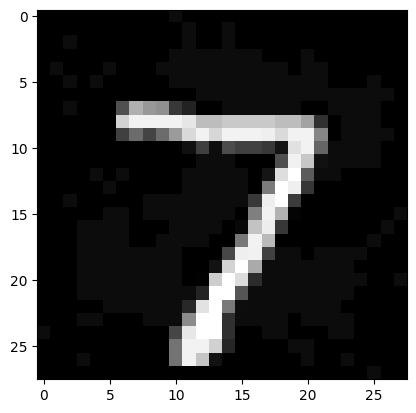

Classifier output: tensor([[-15.6032,  -8.9615,  -6.2962,  -6.4925, -11.9272, -13.5280, -25.8456,
          -0.2441, -10.0360,  -5.6943]])
Classifier prediction: 7


In [186]:
# We are using the same sample input x as before.
x.requires_grad = True
x_prime = FGSM(x, labels, net, eps)
imshow(x_prime[0,0].cpu())
out = net(x_prime)

print('Classifier output:', out.data)
print('Classifier prediction:', torch.argmax(out).item())

In [187]:
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, (out @ c).item())

0 15.3590726852417
1 8.71735668182373
2 6.052058219909668
3 6.248354434967041
4 11.683062553405762
5 13.283873558044434
6 25.6014347076416
8 9.791836738586426
9 5.450198650360107


In [188]:
def accuracy_on_FGSM(net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [189]:
print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

Classifier accuracy on test dataset perturbed with FGSM: 0.8811


# Dual Network

In [190]:
def dual_bounds(x, net, eps):
    '''
    Given a classifier NET, an input image X,
    and the epsilon parameter EPS, returns the lower
    and upper bounds L and U respectively, as well as
    the corresponding sets S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer

    U = []
    L = []
    S = []
    S_plus = []
    S_min = []

    for j in range(0, net.depth - 2):

        u = torch.Tensor([W[0][i] @ x + b[j][i] + eps * torch.norm(W[0][i], 1) for i in range(0, n)])
        l = torch.Tensor([W[0][i] @ x + b[j][i] - eps * torch.norm(W[0][i], 1) for i in range(0, n)])
        #u = torch.Tensor([W[j][i] @ net.z[j-1] + b[j][i] + eps * torch.norm(W[j][i], 1) for i in range(0, n)])
        #l = torch.Tensor([W[j][i] @ net.z[j-1] + b[j][i] - eps * torch.norm(W[j][i], 1) for i in range(0, n)])
        
        U.append(u)
        L.append(l)

        s = [i for i in range(0, n) if l[i] <= 0 and u[i] >= 0]
        s_plus = [i for i in range(0, n) if l[i] <= u[i] and l[i] >= 0]
        s_min = [i for i in range(0, n) if u[i] <= 0 and u[i] >= l[i]]
        S.append(s)
        S_plus.append(s_plus)
        S_min.append(s_min)

    return L, U, S, S_min, S_plus

Given the tuple $(l,u,S,S^-,S^+)$, we are ready to calculate the dual objective itself. This function should take in an input image, the classifier, a vector $c$, and the $(l,u,S,S^-,S^+)$ from the previous function in order to output 
$$
d^*(\vec{x}, \vec{c}) = \max_{\vec{\nu}}(-\vec{\hat{\nu}}_1^T\vec{x}-\epsilon||\vec{\hat{\nu}}_1||_1-\sum_{i=1}^{n-1}\vec{\nu}_{i+1}^T\vec{b}_i+\sum_{i=2}^{n-1}\sum_{j \in S_i}l_{ij}ReLU(\vec{\nu}_{ij}))
$$

One efficient way to compute $\vec{\nu}_i$ is to rewrite it as
$$\vec{\nu}_i= D\vec{\hat{\nu}}_i,$$
where $D$ is a diagonal matrix defined  by
$$
D_{jj}=\begin{cases}
0 & j\in S^-\\
\hat{\nu}_{ij} & j\in S^+\\
\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{ij} & j\in S.
\end{cases}
$$

In [191]:
# Constructs the diagonal D matrix from the S sets, n (the dimensionality
# of the hidden layer), u, and l.
def StoD(S_min, S_plus, S, n, U, L):
    '''
    Given upper and lower bounds U and L, as well
    as the corresponding sets S_MIN, S_PLUS, and S,
    as well as the dimension of the hidden layer N,
    returns the corresponding diagonal matrix D.
    '''
    D = []
    for i in range(0, net.depth - 2):
        d = []
        for j in range(n):
            if j in S[i]:
                d.append((U[i][j] / (U[i][j] - L[i][j])).item())
            elif j in S_plus[i]:
                d.append(1)
            elif j in S_min[i]:
                d.append(0)
            else:
                assert False, 'StoD error.'
        D.append(torch.diag(torch.Tensor(d)).to(device))
    return D

def dual_forward(x, net, c, eps, L, U, S, S_min, S_plus):
    '''
    Calculates the dual objective for classifier NET with input X
    and dual input C and epsilon parameter S. Depends on lower
    and upper bounds L and U, as well as the corresponding sets
    S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer
    D = StoD(S_min, S_plus, S, n, U, L)
    nu = []
    nuh = []

    for i in range(0, net.depth - 1):
        if i == 0:
            nu.append(-c)
        else:
            nu.append(D[net.depth - 2 - i] @ nuh[i - 1])
        nuh.append(W[net.depth - 2 - i].T @ nu[i])
    
    nuh = nuh[::-1]
    nu = nu[::-1]
    
    nu_sum = 0
    for i in range(1, net.depth - 1):
        nu_sum += nu[i].T @ b[i]
    
    relu_sum = 0
    for i in range(0, net.depth - 2):
        for j in range(len(nu[i])):
            if j in S[i]:
                relu_sum += L[i][j] * torch.relu(nu[i][j])
    dual = -1 * (nuh[0].T @ x) - eps * (torch.norm(nuh[0], 1)) - nu_sum + relu_sum

    return dual


In [192]:
eps = 0.05

In [193]:
# We are still using the same sample input x as before.
L, U, S, S_min, S_plus = dual_bounds(x, net, eps)

# print(l, u, S, S_min, S_plus)
# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net, c, 0.1, L, U, S, S_min, S_plus).item())

0 -0.4125630855560303
1 0.3614234924316406
2 -3.8838682174682617
3 -0.666593074798584
4 0.3320655822753906
5 1.5137214660644531
6 -0.12331974506378174
8 -0.28910577297210693
9 0.9625614881515503


In [194]:
def robust_loss(x, label, net, eps, criterion):
    '''
    Given a batch of input images X, its corresponding lables LABEL,
    the classifier NET, epsilon value EPS, and original loss
    function CRITERION, returns the robust loss of NET w/r/t
    the original loss function, on the input image.
    '''
    l, u, S, S_min, S_plus = dual_bounds(x, net, eps)
    # We assume there are 10 classes.
    e_y = torch.zeros(10, 1)
    e_y[label] = 1
    c = e_y @ torch.ones(1, 10) - torch.eye(10)
    J = dual_forward(x, net, c, 0.1, l, u, S, S_min, S_plus).unsqueeze(0)
    try:
        temp = criterion(-J, label.unsqueeze(0))
    except:
        temp = criterion(-J, label.unsqueeze(0).expand(1,10))
    return temp

In [195]:
def robust_train(net, criterion, trainloader, eps, lr=0.001):
    '''
    Trains the classifier NET using the robust version
    of the original loss function CRITERION with paramater EPS,
    using training data from TRAINLOADER and with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
        
    for epoch in range(1):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data
            optimizer.zero_grad()
            loss = 0.0
            for k in range(inputs.shape[0]):
                x = inputs[k].unsqueeze(0)
                label = labels[k].unsqueeze(0)
                loss += robust_loss(x, label, net, eps, criterion)
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

In [196]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [197]:
net = Net(width=256, depth=5)
net.to(device)

eps = 0.05
criterion = nn.CrossEntropyLoss()

robust_train(net, criterion, trainloader, eps, 0.001)

Epoch 0 Iter: 0 Loss 9.180216789245605
Epoch 0 Iter: 500 Loss 0.7155895829200745
Epoch 0 Iter: 1000 Loss 1.59371817111969
Epoch 0 Iter: 1500 Loss 1.2136497497558594
Epoch 0 Iter: 2000 Loss 0.8788227438926697
Epoch 0 Iter: 2500 Loss 0.04887660592794418
Epoch 0 Iter: 3000 Loss 0.710976243019104
Epoch 0 Iter: 3500 Loss 0.007704995572566986
Epoch 0 Iter: 4000 Loss 2.639557361602783
Epoch 0 Iter: 4500 Loss 0.44151362776756287
Epoch 0 Iter: 5000 Loss 0.2148081362247467
Epoch 0 Iter: 5500 Loss 0.047486256808042526
Epoch 0 Iter: 6000 Loss 0.15881361067295074
Epoch 0 Iter: 6500 Loss 3.348794460296631
Epoch 0 Iter: 7000 Loss 0.019914716482162476
Epoch 0 Iter: 7500 Loss 0.252329021692276
Epoch 0 Iter: 8000 Loss 0.01741480827331543
Epoch 0 Iter: 8500 Loss 7.3302717208862305
Epoch 0 Iter: 9000 Loss 0.8763116598129272
Epoch 0 Iter: 9500 Loss 0.0005520583363249898
Epoch 0 Iter: 10000 Loss 0.0014848113059997559
Epoch 0 Iter: 10500 Loss 1.0722182989120483
Epoch 0 Iter: 11000 Loss 0.5698018670082092
Epo

In [198]:
test_iter = iter(testloader)

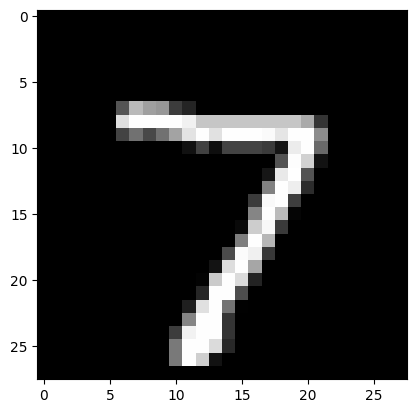

Classifier output: tensor([[  1.8000,   5.0903,  10.0018, -24.9255,   1.6822, -22.2126, -10.7854,
          27.1376, -14.0135,   0.6119]])
Classifier prediction: 7


In [199]:
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

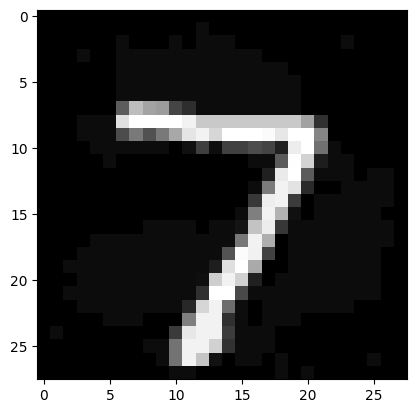

Classifier output: tensor([[  3.9568,   4.3175,  14.0687, -23.1187,  -0.1311, -23.8416, -11.6247,
          26.0476, -14.5538,  -1.1077]])
Classifier prediction: 7


In [200]:
# We are using the same sample input x as before.
x.requires_grad = True
x_prime = FGSM(x, labels, net, eps)
imshow(x_prime[0,0].cpu())
out = net(x_prime)

print('Classifier output:', out.data)
print('Classifier prediction:', torch.argmax(out).item())

In [201]:
def accuracy(net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [202]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.6219


In [203]:
def accuracy_on_FGSM(net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [204]:
print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

Classifier accuracy on test dataset perturbed with FGSM: 0.4771
